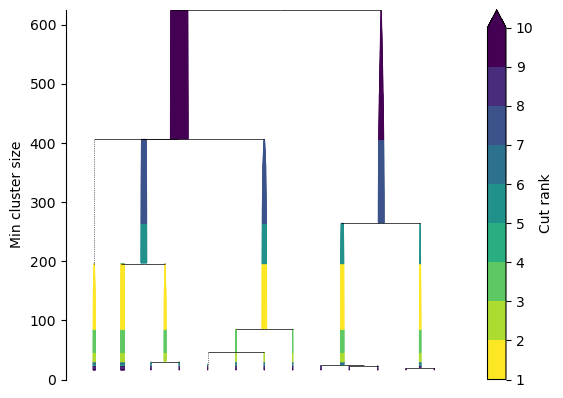

In [14]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from plscan import PLSCAN

warnings.filterwarnings("ignore", category=FutureWarning)
data = np.load("data/clusterable/sources/clusterable_data.npy")

mc = 15
n = data.shape[0]
c = PLSCAN(min_samples=mc).fit(data)
c.leaf_tree_.plot()
plt.show()

Compute $d_{\rm s}$ distance matrix. Reserve first row & column for $\top$. Iterate in decreasing topology changing $m_{\rm c}$ thresholds. Write distances for all points in the same leaf-cluster. Also update distances to $\top$ for all noise points (i.e., points not in any leaf cluster).

In [15]:
dists = np.full((n + 1, n + 1), np.inf)
for size in c._persistence_trace.min_size[::-1]:
    labels, probs = c.min_cluster_size_cut(size)
    for i in range(-1, labels.max() + 1):
        pts = np.flatnonzero(labels == i) + 1
        if i == -1:
            dists[0, pts] = size
            dists[pts, 0] = size
        if i > -1:
            X, Y = np.meshgrid(pts, pts)
            dists[X, Y] = size
dists -= mc

Plot the distance matrix. Some distances remain infinite, as expected.

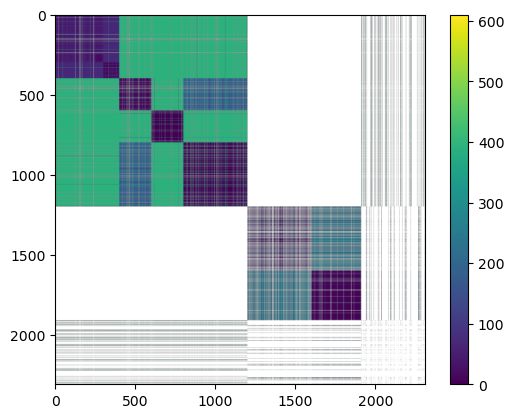

In [16]:
plt.imshow(dists)
plt.colorbar()
plt.show()

This computation does not produce 0 self-distances for all points!

In [17]:
np.all(np.diag(dists) == 0)

np.False_

Update distances with connections through $\top$ corrects the distance matrix:

In [24]:
# Distance both points connect to top
through_top = np.maximum(*np.meshgrid(dists[0, 1:], dists[1:, 0]))
# Final distance is minimum of direct or through top
dists2 = np.minimum(dists[1:, 1:], through_top)

In [25]:
print(np.all(np.diag(dists2) == 0))

True


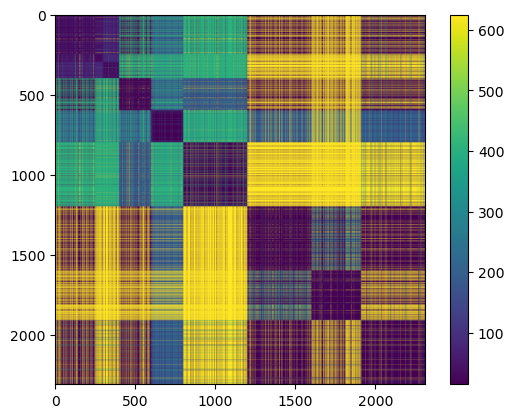

In [26]:
plt.imshow(dists2 + mc)
plt.colorbar()
plt.show()

Compute VietorisRips persistence:

In [20]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(
    homology_dimensions=[0], reduced_homology=False, metric="precomputed"
)
barcodes = VR.fit_transform([dists2])

The barcode death sizes do not match what we find in the leaf tree. Later size
thresholds are not detected. Possibly due to connections through $\top$?

In [21]:
np.unique(barcodes[0][:, 1] + mc)

array([ 19.,  23.,  24.,  26.,  30.,  46.,  85., 196.,  inf])

In [22]:
np.unique(c._leaf_tree.max_size.astype(int)[c._leaf_tree.min_size < c._leaf_tree.max_size])

array([  19,   23,   24,   26,   30,   46,   85,  196,  264,  406,  625,
       2309])

This problem disappears if $\top$ is not included, except that does not detect
the leaf-death at $m_{\rm c} = 26$:

In [23]:
dists3 = np.full((n, n), np.inf)
for size in c._persistence_trace.min_size[::-1]:
    labels, probs = c.min_cluster_size_cut(size)
    for i in range(-1, labels.max() + 1):
        pts = np.flatnonzero(labels == i)
        if i > -1:
            X, Y = np.meshgrid(pts, pts)
            dists3[X, Y] = size
dists3 -= mc
np.fill_diagonal(dists3, 0)

np.unique(VR.fit_transform([dists3])[0][:, 1] + mc)

array([ 19.,  23.,  24.,  30.,  46.,  85., 196., 264., 406.,  inf])